In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
sns.set_context("paper")
sns.set_style('ticks')

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.dpi'] = 600

In [4]:
paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df_koik = pd.concat([utils.read_aggregated_data(path) for path in paths], axis=0)
df_koik.shape

(1896, 41)

In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

def treeni_ols_no_p_drop(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    X = sm.add_constant(X)
    kasutusel_featured = {col: 1 for col in X.columns}

    model = sm.OLS(y, X)

    results = model.fit()

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    print()
    print(results.summary())
    return results, X, y

In [6]:
def muuda_veergude_nimed_eestikeelseks(df):
    eesti_nimed = {
        'const': 'Konstant',
        'my_bpoints': 'Minu murde punktid',
        'neighbour_bpoints': 'Naabrite murde punktid',
        'distant_bpoints': 'Kaugemate murde punktid',
        'my_raw_mean2': 'Minu keskmine 2',
        'neighbour_raw_mean2': 'Naabrite keskmine 2',
        'distant_raw_mean2': 'Kaugemate keskmine 2',
        'my_points': 'Minu punktid',
        'neighbour_points': 'Naabrite punktid',
        'distant_points': 'Kaugemate punktid',
        'my_points_m1': 'Minu pöördpunktid',
        'my_points_log': 'Minu punktide logaritm',
        'my_points_logm1': 'Minu pöördpunktide logaritm',
        'neighbour_points_m1': 'Naabrite pöördpunktid',
        'neighbour_points_log': 'Naabrite punktide logaritm',
        'neighbour_points_logm1': 'Naabrite pöördpunktide logaritm',
        'distant_points_m1': 'Kaugemate pöördpunktid',
        'distant_points_log': 'Kaugemate punktide logaritm',
        'distant_points_logm1': 'Kaugemate pöördpunktide logaritm',
        'mse_treeningul': 'MSE treeningul',
    }
    df = df.rename(columns=eesti_nimed)
    return df

# Treenime OLS koos kõigi tunnustega ja ei võta midagigi välja

In [7]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols_no_p_drop(suurX, suury)

0.433704027464205;11.581102038960433;-3914.7316556154747;-3774.9128594766585;
                            OLS Regression Results                            
Dep. Variable:            my_rel_diff   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     322.9
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:46:45   Log-Likelihood:                 1977.4
No. Observations:                8030   AIC:                            -3915.
Df Residuals:                    8010   BIC:                            -3775.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [14]:
# summary_table = pd.read_html(result.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\all_regressioon_summary2.xlsx", engine='openpyxl') as writer:
#     summary_table[0].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=len(summary_table[0]) + 2, startcol=0, index=True)

# Teeme alumisele ruudule tunnused eraldi analüüsi kokku
## Mypoints kokku

In [81]:
from statsmodels.genmod import families

def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    X = sm.add_constant(X)
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)

        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0
                
    return results, X, y

In [82]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[["my_points_log", "my_points_logm1"]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result1, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result1.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\minu_punktid_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
    
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.263
Method:                 Least Squares   F-statistic:                              1435.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:14:18   Log-Likelihood:                          535.04
No. Observations:                8030   AIC:                                     -1066.
Df Residuals:                    8028   BIC:                                     -1052.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
my_points_log       0.1224      0.007     18.769      0.000       0.110       0.135
my_points_logm1    -0.8249      0.016    -51.736      0.000      -0.856      -0.794
==============================================================================
Omnibus:                     3067.451   Durbin-Watson:                   0.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32510.574
Skew:                           1.527   Prob(JB):                         0.00
Kurtosis:                      12.373   Cond. No.                         3.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

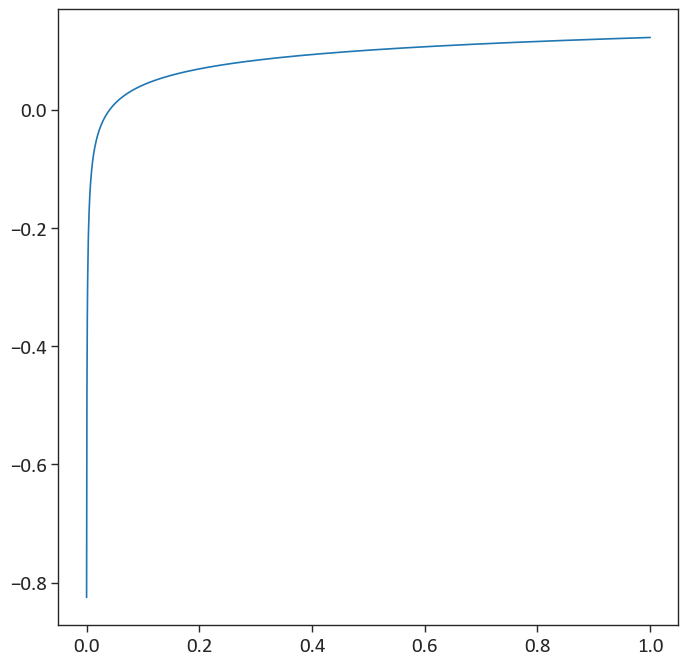

In [ ]:
punktide_arv = np.arange(2, 1600)
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y1 = log_punktid * result1.params["my_points_log"] + poord_log_punktid * result1.params["my_points_logm1"]
sns.lineplot(x=punktide_arv, y=y1)

## Neighbour punktid kokku

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[["neighbour_points_logm1", "neighbour_points_log"]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result2, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result2.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\naaber_punktid_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1549.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          6.31e-310
Time:                        12:49:25   Log-Likelihood:                 402.61
No. Observations:                8030   AIC:                            -801.2
Df Residuals:                    8028   BIC:                            -787.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0760      0.005     16.108      0.000       0.067       0.085
neighbour_points_logm1    -0.9843      0.025    -39.356      0.000      -1.033      -0.935
==============================================================================
Omnibus:                     3111.160   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35009.805
Skew:                           1.535   Prob(JB):                         0.00
Kurtosis:                      12.758   Cond. No.                         9.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

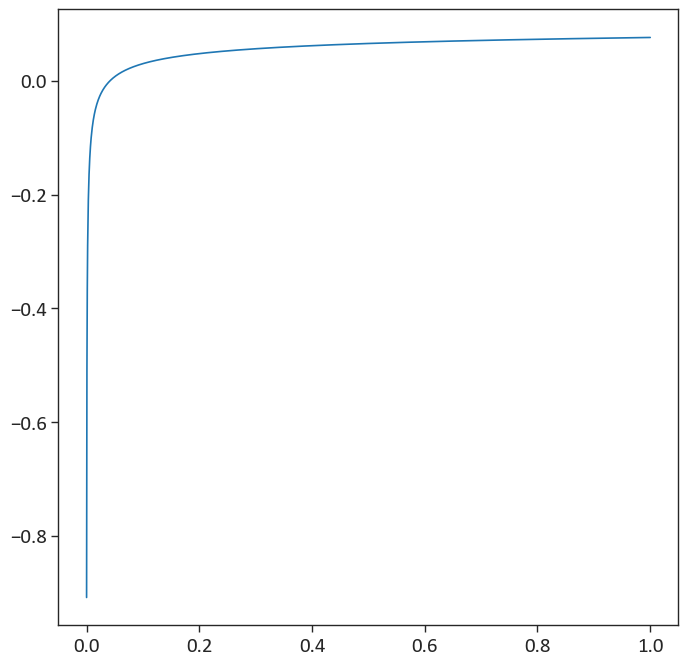

In [ ]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y2 = poord_log_punktid * result2.params["neighbour_points_logm1"] + const*result2.params["const"]
sns.lineplot(x=punktide_arv, y=y2)

## Distant

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[["distant_points_log", "distant_points_logm1"]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result3, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result3.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\kauge_punktid_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.221
Model:                            OLS   Adj. R-squared (uncentered):              0.221
Method:                 Least Squares   F-statistic:                              1142.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        12:52:42   Log-Likelihood:                          313.21
No. Observations:                8030   AIC:                                     -622.4
Df Residuals:                    8028   BIC:                                     -608.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
distant_points_log       0.0906      0.007     13.493      0.000       0.077       0.104
distant_points_logm1    -0.7491      0.017    -45.057      0.000      -0.782      -0.717
==============================================================================
Omnibus:                     3087.247   Durbin-Watson:                   0.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33715.018
Skew:                           1.529   Prob(JB):                         0.00
Kurtosis:                      12.561   Cond. No.                         3.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

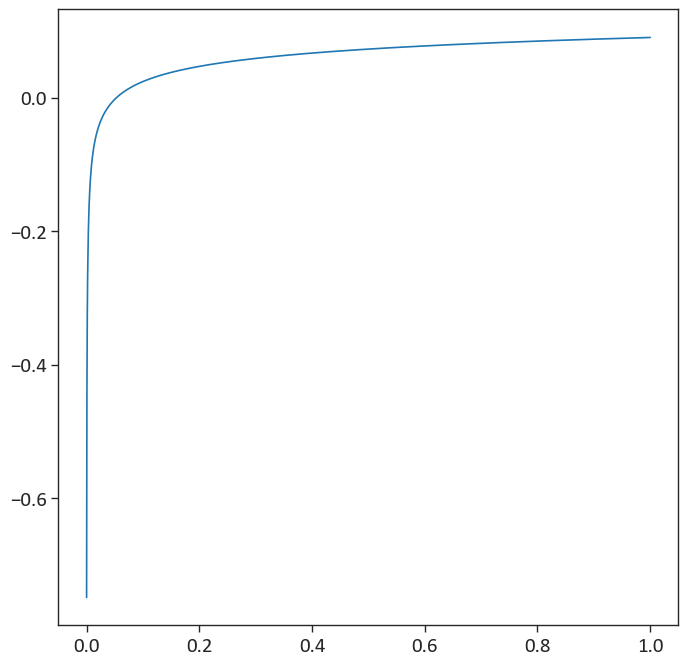

In [ ]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape)

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y3 = log_punktid * result3.params["distant_points_log"] + poord_log_punktid * result3.params["distant_points_logm1"]
sns.lineplot(x=punktide_arv, y=y3)

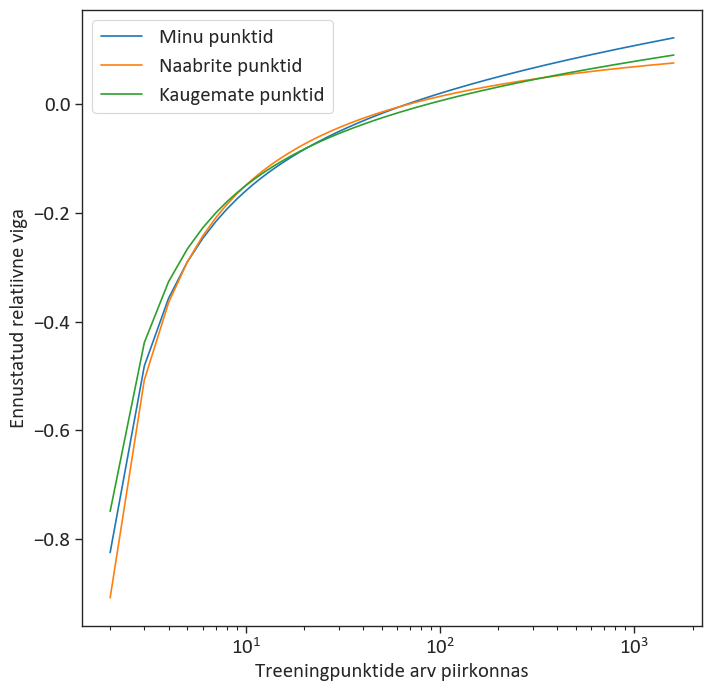

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Minu punktid")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naabrite punktid")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugemate punktid")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

plt.savefig("plots/kirjalik_osa/all_points_combos.png")

## Kombineerime need ära

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suurX["my_points_combo"] = suurX.my_points_log * result1.params["my_points_log"] + suurX.my_points_logm1 * result1.params["my_points_logm1"]


suurX["neighbour_points_combo"] = suurX.neighbour_points_logm1 * result2.params["neighbour_points_logm1"] + np.ones(shape=suurX.shape[0])*result2.params["const"]


suurX["distant_points_combo"] = suurX.distant_points_log * result3.params["distant_points_log"] + suurX.distant_points_logm1 * result3.params["distant_points_logm1"]


suurX.drop([col for col in suurX.columns if "combo" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result4, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result4.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\punkti_combod_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.268
Model:                            OLS   Adj. R-squared (uncentered):              0.268
Method:                 Least Squares   F-statistic:                              1468.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:09:32   Log-Likelihood:                          559.55
No. Observations:                8030   AIC:                                     -1115.
Df Residuals:                    8028   BIC:                                     -1101.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_points_combo            0.7407      0.041     17.889      0.000       0.660       0.822
neighbour_points_combo     0.3049      0.043      7.011      0.000       0.220       0.390
==============================================================================
Omnibus:                     3136.231   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34371.491
Skew:                           1.559   Prob(JB):                         0.00
Kurtosis:                      12.644   Cond. No.                         4.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Ennustatud relatiivne viga')

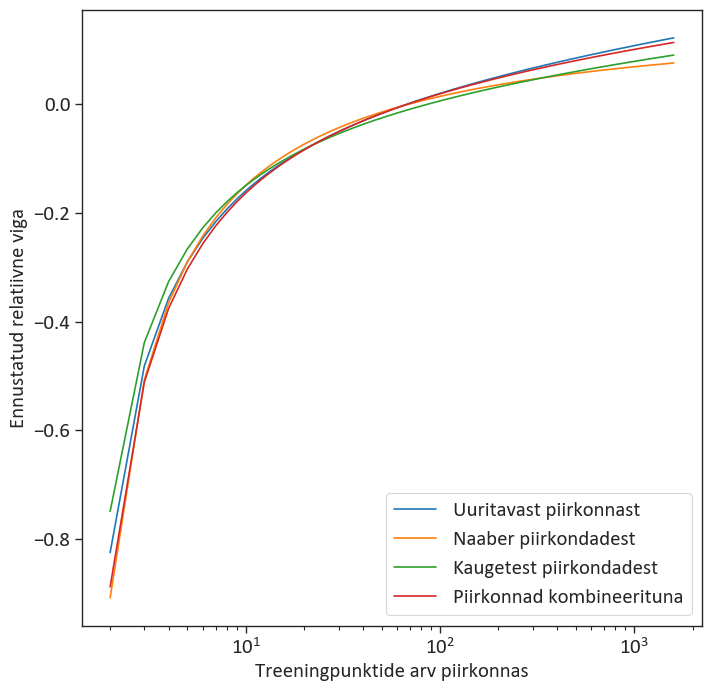

In [ ]:
# const4 = np.ones(shape=y1.shape) 
y4 = y1 * result4.params["my_combo"] + y2 * result4.params["neighbour_combo"]# + const4 * result4.params["const"]

fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Uuritavast piirkonnast")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naaber piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugetest piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y4, ax=ax, label="Piirkonnad kombineerituna")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

# plt.savefig("plots/kirjalik_osa/all_points_combos.png")

## Bpoints

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
tagavarasuurX = suurX.copy()
suurX.drop([col for col in suurX.columns if "bpoints" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result5, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result5.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\bpunktide_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     396.5
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          3.44e-240
Time:                        13:04:27   Log-Likelihood:                 249.19
No. Observations:                8030   AIC:                            -490.4
Df Residuals:                    8026   BIC:                            -462.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0618      0.009      6.606      0.000       0.043       0.080
my_bpoints           -0.4097      0.014    -28.897      0.000      -0.437      -0.382
neighbour_bpoints    -0.1139      0.018     -6.473      0.000      -0.148      -0.079
distant_bpoints      -0.0604      0.019     -3.119      0.002      -0.098      -0.022
==============================================================================
Omnibus:                     3016.173   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31095.883
Skew:                           1.503   Prob(JB):                         0.00
Kurtosis:                      12.160   Cond. No.                         9.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Ennustatud relatiivne viga')

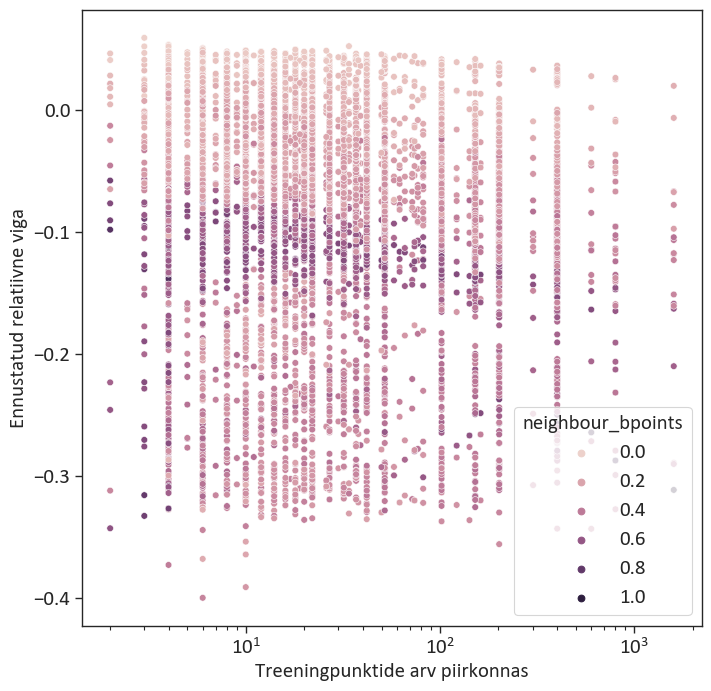

In [ ]:
y5 = newX.const * result5.params["const"] +\
    newX.my_bpoints * result5.params["my_bpoints"] + \
    newX.neighbour_bpoints * result5.params["neighbour_bpoints"] + \
    newX.distant_bpoints * result5.params["distant_bpoints"]


fig, ax = plt.subplots()
ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2
sns.scatterplot(x=inverse_minimax(tagavarasuurX.my_points), y=y5, ax=ax, hue=tagavarasuurX.neighbour_bpoints)

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

# plt.savefig("plots/kirjalik_osa/bpoints_combo_kaalud.png")

## raw_mean jaoks
ei ole mõtet sest r tuleb mingi 0.006

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suurX.drop([col for col in suurX.columns if "raw_mean" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result6, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result6.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\raw_mean_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     176.0
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          1.52e-110
Time:                        13:04:50   Log-Likelihood:                -49.848
No. Observations:                8030   AIC:                             107.7
Df Residuals:                    8026   BIC:                             135.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2551      0.009    -27.905      0.000      -0.273      -0.237
my_raw_mean2            0.2127      0.044      4.828      0.000       0.126       0.299
neighbour_raw_mean2     0.4300      0.041     10.475      0.000       0.350       0.510
distant_raw_mean2       0.2821      0.027     10.269      0.000       0.228       0.336
==============================================================================
Omnibus:                     2427.181   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20539.728
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                      10.454   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Ennustatud relatiivne viga')

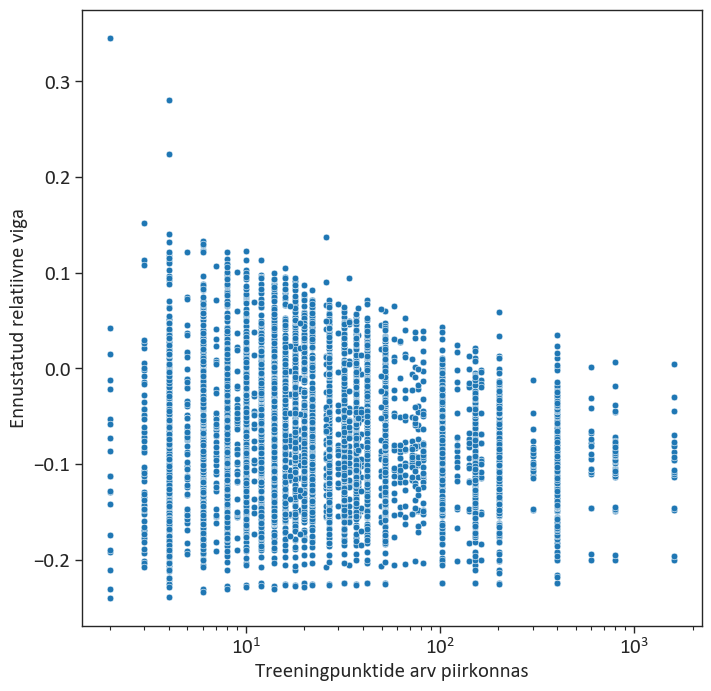

In [ ]:
y5 = newX.const * result6.params["const"] +\
    newX.my_raw_mean2 * result6.params["my_raw_mean2"] + \
    newX.neighbour_raw_mean2 * result6.params["neighbour_raw_mean2"] + \
    newX.distant_raw_mean2 * result6.params["distant_raw_mean2"]


fig, ax = plt.subplots()
ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2
sns.scatterplot(x=inverse_minimax(tagavarasuurX.my_points), y=y5, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

# plt.savefig("plots/kirjalik_osa/raw_mean_combo.png")

## Vaatame mis kombod olemas on juba

In [ ]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
suurX = reg_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

# TODO üle käia ega need olemasolevad elemendid ei muutu
suurX["my_points_combo"] = suurX.my_points_log * result1.params["my_points_log"] + suurX.my_points_logm1 * result1.params["my_points_logm1"]
suurX["neighbour_points_combo"] = suurX.neighbour_points_logm1 * result2.params["neighbour_points_logm1"] + np.ones(shape=suurX.shape[0])*result2.params["const"]
# suurX["distant_points_combo"] = suurX.distant_points_log * result3.params["distant_points_log"] + suurX.distant_points_logm1 * result3.params["distant_points_logm1"]
suurX["points_combo"] =  suurX.my_points_combo * result4.params["my_points_combo"] + suurX.neighbour_points_combo * result4.params["neighbour_points_combo"]
suurX["bpoints_combo"] = suurX.my_bpoints * result5.params["my_bpoints"] + suurX.neighbour_bpoints * result5.params["neighbour_bpoints"] + suurX.distant_bpoints * result5.params["distant_bpoints"] + np.ones(shape=suurX.shape[0]) * result5.params["const"] 

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'


suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
        'my_points','neighbour_points_combo', 'my_points_combo', 
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
       'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
       'distant_points_logm1', ], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result7, newX, newy = treeni_ols(suurX, suury)
regressioon_mudel, newX, newy = treeni_ols(suurX, suury)

# summary_table = pd.read_html(result7.summary().as_html(), header=0, index_col=0)
# with pd.ExcelWriter(r"plots\kirjalik_osa\engineered_kaalud.xlsx", engine='openpyxl') as writer:
#     summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     1102.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:09:44   Log-Likelihood:                 1792.9
No. Observations:                8030   AIC:                            -3574.
Df Residuals:                    8024   BIC:                            -3532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0906      0.009     -9.912      0.000      -0.109      -0.073
neighbour_raw_mean2     0.5247      0.028     18.667      0.000       0.470       0.580
distant_raw_mean2       0.6185      0.025     24.324      0.000       0.569       0.668
mse_treeningul         -0.2943      0.013    -22.516      0.000      -0.320      -0.269
points_combo            1.0079      0.020     49.195      0.000       0.968       1.048
bpoints_combo           0.8917      0.028     32.255      0.000       0.838       0.946
==============================================================================
Omnibus:                     3608.668   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45414.162
Skew:                           1.817   Prob(JB):                         0.00
Kurtosis:                      14.069   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

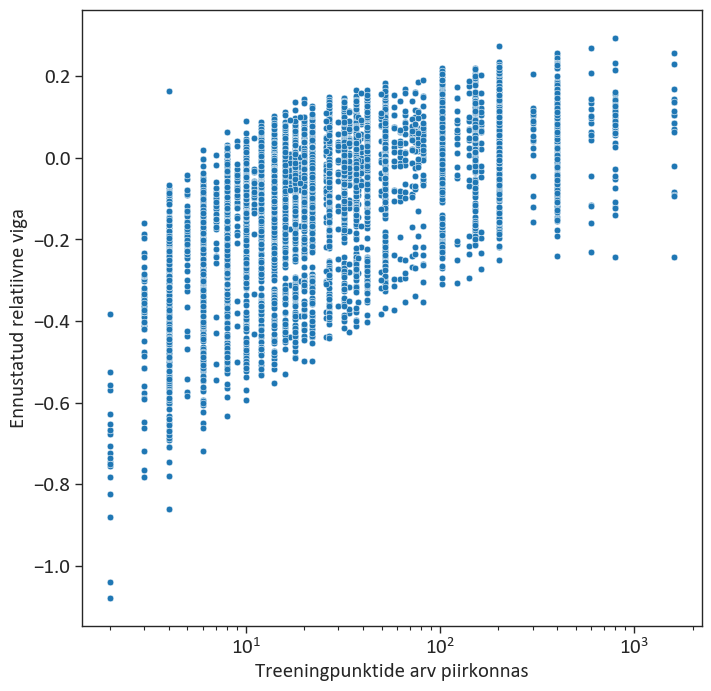

In [ ]:
y7 = newX.const * result7.params["const"] +\
    newX.neighbour_raw_mean2 * result7.params["neighbour_raw_mean2"] + \
    newX.distant_raw_mean2 * result7.params["distant_raw_mean2"] +\
    newX.mse_treeningul * result7.params["mse_treeningul"] +\
    newX.points_combo * result7.params["points_combo"] +\
    newX.bpoints_combo * result7.params["bpoints_combo"]

fig, ax = plt.subplots()
ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2
sns.scatterplot(x=inverse_minimax(tagavarasuurX.my_points), y=y7, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

# plt.savefig("plots/kirjalik_osa/final.png")

# Jääksutunnused

In [ ]:
np.abs(result7.params)

const                  0.090626
neighbour_raw_mean2    0.524725
distant_raw_mean2      0.618484
mse_treeningul         0.294337
points_combo           1.007869
bpoints_combo          0.891721
dtype: float64

In [ ]:
np.argsort(np.abs(result7.params))

const                  0
neighbour_raw_mean2    3
distant_raw_mean2      1
mse_treeningul         2
points_combo           5
bpoints_combo          4
dtype: int64

In [ ]:
for a in np.argsort(np.abs(result7.params))[-2::-1]:
    print(result7.params[a])

0.8917212840674075
0.6184839535274352
0.5247254121490286
-0.2943370893379894
-0.0906256446232183


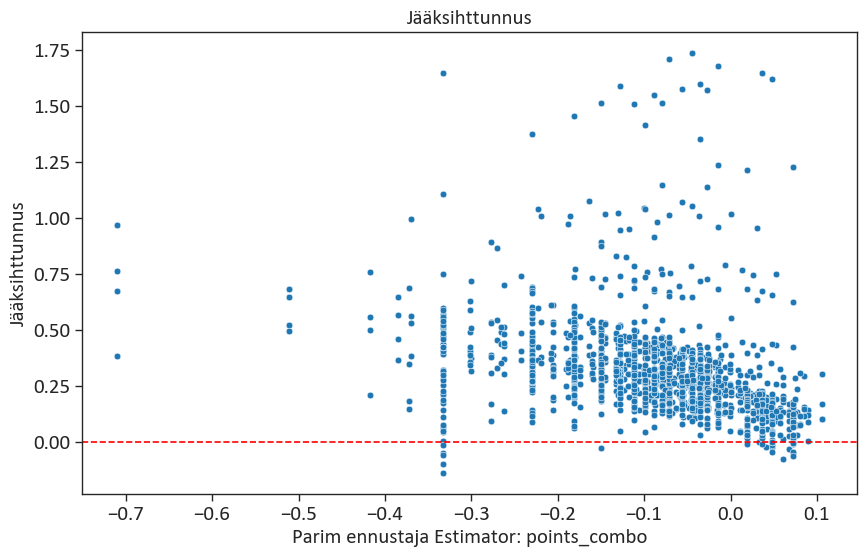

In [ ]:
model = result7
best_estimator = newX.columns[np.argmax(np.abs(model.params))]

y_pred = model.predict(newX)
residuals = y - y_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=newX[best_estimator], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Parim ennustaja Estimator: {best_estimator}')
plt.ylabel('Jääksihttunnus')
plt.title('Jääksihttunnus')
plt.show()

bpoints_combo


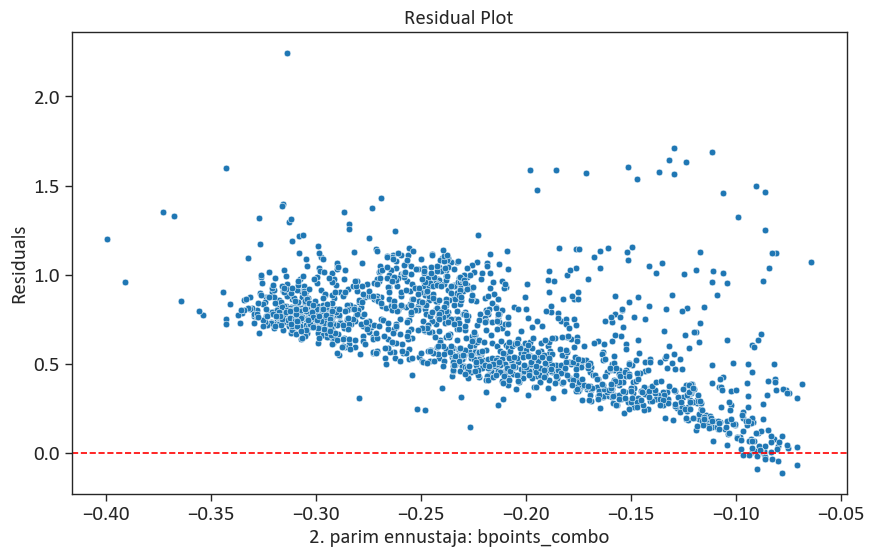

distant_raw_mean2


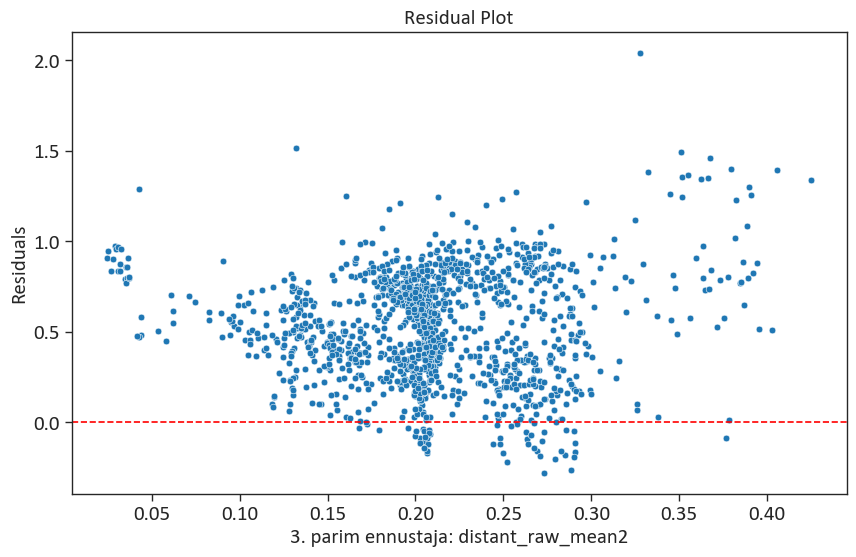

neighbour_raw_mean2


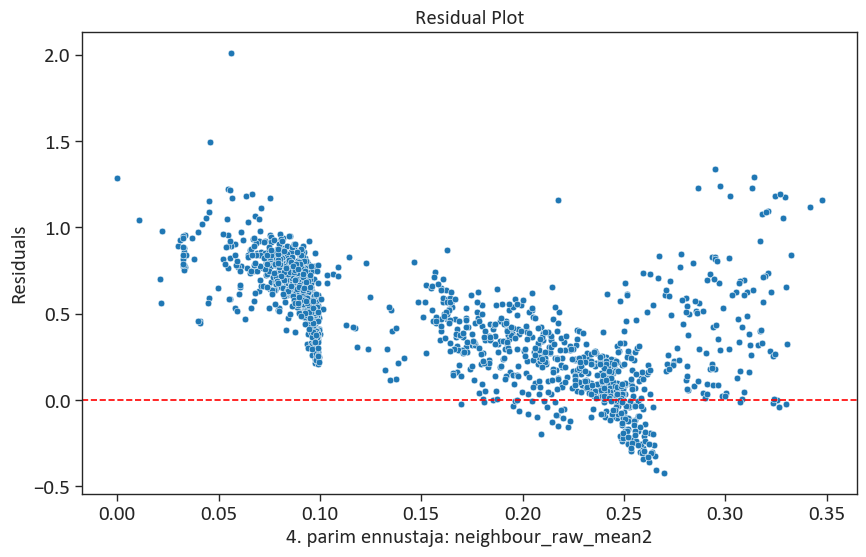

mse_treeningul


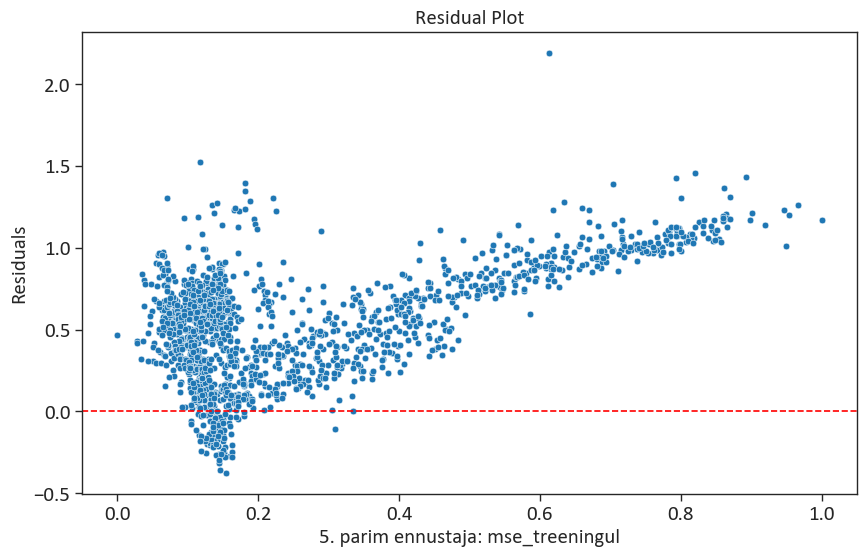

const


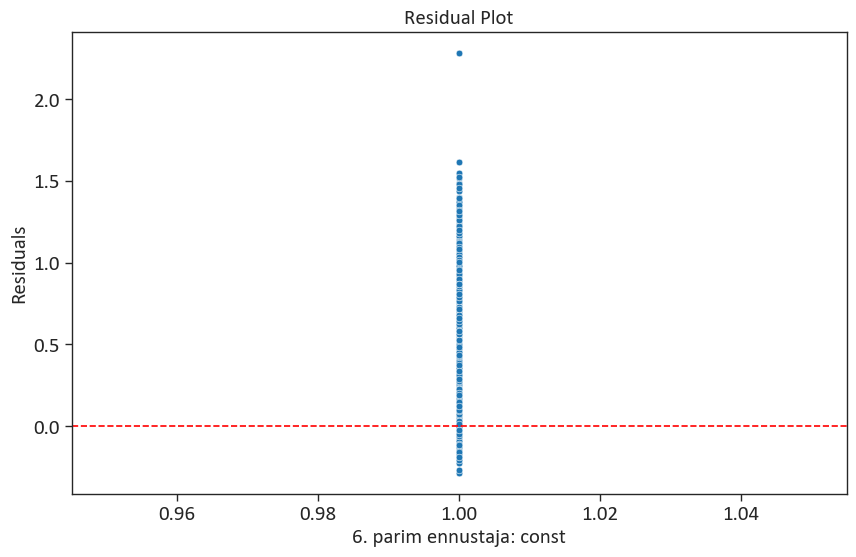

In [ ]:
jarjekord = np.argsort(np.abs(result7.params))[-2::-1]
for idx, best_est in enumerate(jarjekord):
    best_est = model.params.keys()[best_est]
    print(best_est)
    residuals = residuals - model.params[best_est] * newX[best_est]

    # Create the residual plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=newX[best_est], y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'{idx+2}. parim ennustaja: {best_est}')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

# Jamps

In [93]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)
    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      
        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
y = suury.copy()

In [102]:
X

,my_raw_mean2,neighbour_raw_mean2,distant_raw_mean2,mse_treeningul,points_combo,bpoints_combo,target
0,0.030495,0.045846,0.132100,0.117201,-0.709571,-0.342840,-0.125387
1,0.008435,0.060346,0.176193,0.114095,-0.385215,-0.228389,-0.722004
2,0.010080,0.069200,0.186841,0.150029,-0.370296,-0.259462,-0.689112
3,0.010315,0.078310,0.207042,0.141558,-0.277046,-0.265142,-0.670101
4,0.011948,0.086812,0.192057,0.147867,-0.270750,-0.290848,-0.636855
...,...,...,...,...,...,...,...
8025,0.110586,0.272913,0.386123,0.206191,0.032643,-0.046190,1.402667
8026,0.109774,0.289316,0.392150,0.223869,0.060407,-0.078920,1.435507
8027,0.112182,0.293275,0.379305,0.220455,0.074860,-0.043386,1.807103
8028,0.109703,0.276164,0.425081,0.225951,0.084464,-0.047011,1.820733


In [118]:
import statsmodels.formula.api as smf
uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
X = reg_scaler.fit_transform(suurX,)
X = pd.DataFrame(X, columns=uuritavad_col)

# TODO üle käia ega need olemasolevad elemendid ei muutu
X["my_points_combo"] = X.my_points_log * result1.params["my_points_log"] + \
    X.my_points_logm1 * result1.params["my_points_logm1"]
X["neighbour_points_combo"] = X.neighbour_points_logm1 * \
    result2.params["neighbour_points_logm1"] + \
    np.ones(shape=X.shape[0])*result2.params["const"]
# X["distant_points_combo"] = X.distant_points_log * result3.params["distant_points_log"] + X.distant_points_logm1 * result3.params["distant_points_logm1"]
X["points_combo"] = X.my_points_combo * result4.params["my_points_combo"] + \
    X.neighbour_points_combo * result4.params["neighbour_points_combo"]
X["bpoints_combo"] = X.my_bpoints * result5.params["my_bpoints"] + X.neighbour_bpoints * result5.params["neighbour_bpoints"] + \
    X.distant_bpoints * result5.params["distant_bpoints"] + \
    np.ones(shape=X.shape[0]) * result5.params["const"]

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'


X.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints',
        'my_points', 'neighbour_points_combo', 'my_points_combo',
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
        'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
        'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
        'distant_points_logm1', ], axis=1, inplace=True)

for col in X.columns:
    X[col] += 0.1

# result7, newX, newy = treeni_ols(X, suury)
# regressioon_mudel, newX, newy = treeni_ols(X, suury)
X["target"] = y
model = smf.glm(formula='target ~ points_combo + bpoints_combo + my_raw_mean2 + neighbour_raw_mean2 + distant_raw_mean2 + mse_treeningul',
                data=X, family=sm.families.Tweedie())
result = model.fit()
# ['test', 'links', 'Family', 'Gamma', 'Gaussian', 'Poisson','InverseGaussian', 'Binomial', 'NegativeBinomial', 'Tweedie']
result7.summary()

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [ ]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    X = sm.add_constant(X)
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)

        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0
                
    return results, X, y

# Loeme sisse ja ennustame?

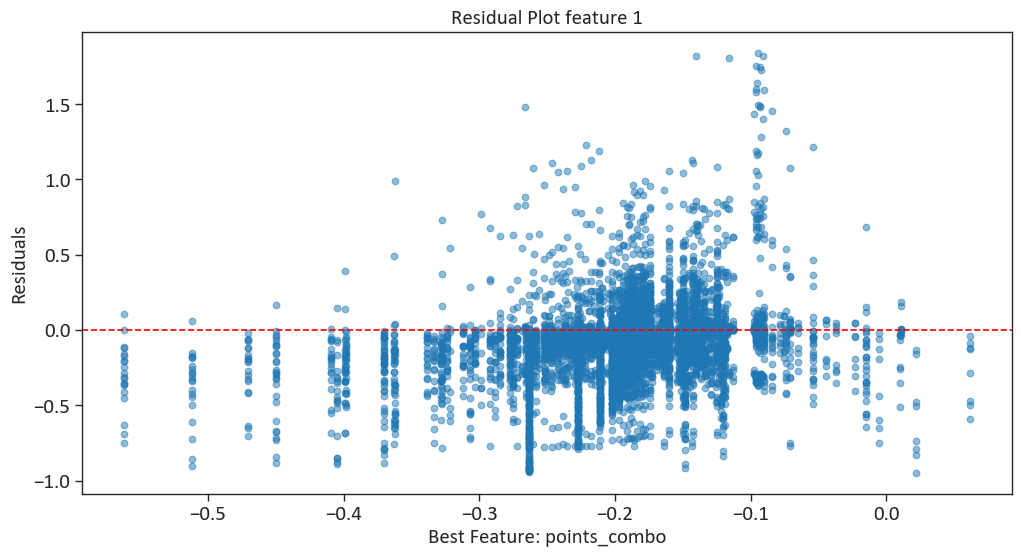

In [ ]:
# Make predictions on the test set
y_pred = regressioon_mudel.predict(newX)

# Calculate the residuals
residuals = newy - y_pred

# Plot the residual plot with the best feature on the x-axis
x = newX.points_combo * result7.params["points_combo"] + result7.params["const"]
plt.figure(figsize=(12, 6))
plt.scatter(x=x, y=newy, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: points_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 1")
plt.show()


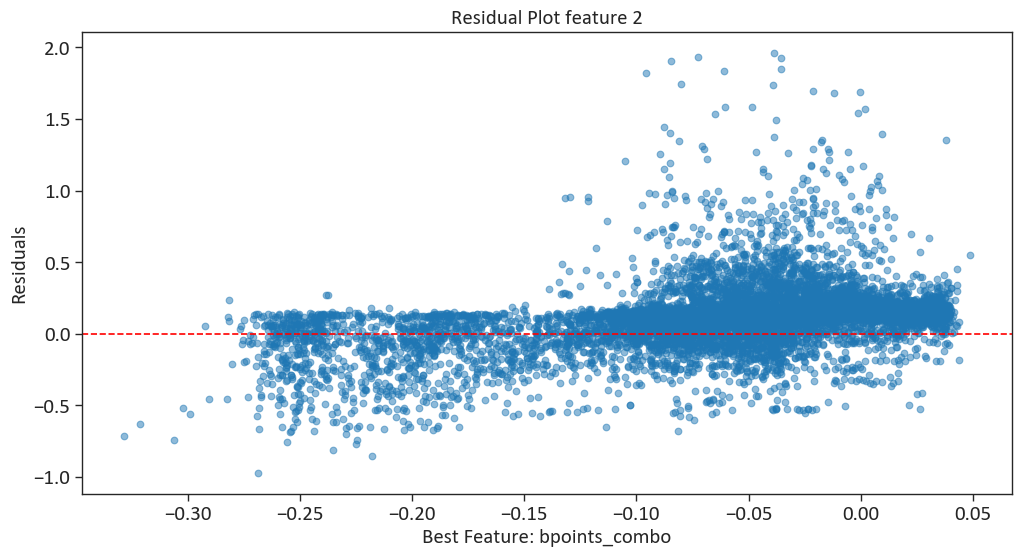

In [ ]:
# Make predictions on the test set

# Calculate the residuals
y2 = newy - x

# Plot the residual plot with the best feature on the x-axis
x2 = newX.bpoints_combo * result7.params["bpoints_combo"] 
plt.figure(figsize=(12, 6))
plt.scatter(x=x2, y=y2, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: bpoints_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 2")
plt.show()